# Amazon prime video view project





Amazon Prime is a membership subscription from Amazon that gives users one-day or two-day delivery and streaming music and video. From 2016, Prime Video launched worldwide. 

In this project, I will show feature engineering process and machine learning regression models to predict the video count. The hyperparameters are tuned to get the best performance. 

# Part I: load data

In [ ]:
# load packages and install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn as sl
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id = "1bw6HvYfaz8KFPB3Gs3mESF_kJoITIIJk"
file = drive.CreateFile({'id':id}) 
file.GetContentFile('TVdata.txt')

In [ ]:
df = pd.read_csv('TVdata.txt')
df.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,import_id,release_year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category
0,385504,307127.605608,1,3,lionsgate,2013,"Action,Thriller,Drama",69614,15000000,42930462,6.5,112.301017,51,other award,PG-13,1.710000
1,300175,270338.426375,1,3,lionsgate,2013,"Comedy,Crime,Thriller",46705,15000000,3301046,6.5,94.983250,41,no award,R,3.250000
2,361899,256165.867446,1,3,other,2012,"Crime,Drama",197596,26000000,37397291,7.3,115.763675,58,other award,R,2.646667
3,308314,196622.720996,3,4,lionsgate,2008,"Thriller,Drama,War,Documentary,Mystery,Action",356339,15000000,15700000,7.6,130.703583,94,Oscar,R,1.666667
4,307201,159841.652064,1,3,lionsgate,2013,"Crime,Thriller,Mystery,Documentary",46720,27220000,8551228,6.4,105.545533,37,other award,R,3.066667



##The data columns are:
Video _id: A unique id for a movie

Cvt_per_day: Cumulated view time per day

weighted_categorical_position: Average vertical positions on the home page that the movie was placed

weighted_horizontal_poition: Average horizontal positions on the home page that the movie was placed

Genres: genres of the movie

release_year: the year the movie was released

imdb_votes: the number of votes on IMDB, typically higher the votes the better

budget: budget of the movie production, typically the higher the better

boxoffice: gross box office in US as updated on IMDB, typically the higher the better

imdb_rating: ratings on IMDB

duration_in_mins: How long is the content in minutes

mpaa: MPAA ratings

Awards: TVPG ratings

lmport_id: Content partners

Metacritic_score: Metacritic score on IMDB page. Typically, the higher the better

Star_cateogry: A score to measure how popular the actor/actress are associated with the movie

# Part II: Understand the Raw Dataset

In [ ]:
# check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_id                       4226 non-null   int64  
 1   cvt_per_day                    4226 non-null   float64
 2   weighted_categorical_position  4226 non-null   int64  
 3   weighted_horizontal_poition    4226 non-null   int64  
 4   import_id                      4226 non-null   object 
 5   release_year                   4226 non-null   int64  
 6   genres                         4226 non-null   object 
 7   imdb_votes                     4226 non-null   int64  
 8   budget                         4226 non-null   int64  
 9   boxoffice                      4226 non-null   int64  
 10  imdb_rating                    4226 non-null   float64
 11  duration_in_mins               4226 non-null   float64
 12  metacritic_score               4226 non-null   i

In [ ]:
# check the unique values for each column
df.nunique()

video_id                         4226
cvt_per_day                      4226
weighted_categorical_position      37
weighted_horizontal_poition        68
import_id                           4
release_year                       97
genres                           1165
imdb_votes                       2282
budget                            253
boxoffice                         410
imdb_rating                        85
duration_in_mins                 4097
metacritic_score                   90
awards                              5
mpaa                                6
star_category                     630
dtype: int64

In [ ]:
# check whether there are any duplicate
df['video_id'].duplicated().sum()

0

There is no duplicate in video_id. 

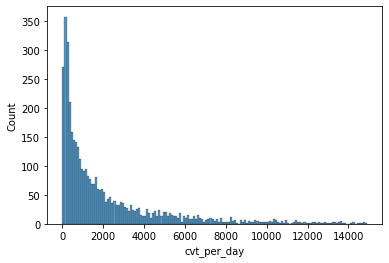

In [ ]:
# Get target variable and plot
y = df['cvt_per_day']
sns.histplot(data = df, x = 'cvt_per_day', bins=range(0,15000,100))

In [ ]:
# check missing values
df.isnull().sum()

video_id                         0
cvt_per_day                      0
weighted_categorical_position    0
weighted_horizontal_poition      0
import_id                        0
release_year                     0
genres                           0
imdb_votes                       0
budget                           0
boxoffice                        0
imdb_rating                      0
duration_in_mins                 0
metacritic_score                 0
awards                           0
mpaa                             0
star_category                    0
dtype: int64

There is no NAN in the dataset? let's see in the later analysis.

In [ ]:
# understand Numerical feature
# discrete/continuous
df[['weighted_categorical_position', 'weighted_horizontal_poition', 'imdb_votes', 'budget', 'boxoffice', 'imdb_rating', 'duration_in_mins', 'metacritic_score', 'star_category']].describe(percentiles=[0.1,0.25,0.5,0.75,0.95])

,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category
count,4226.000000,4226.000000,4226.000000,4.226000e+03,4.226000e+03,4226.000000,4226.000000,4226.000000,4226.000000
mean,7.782537,28.103644,6462.924042,2.150743e+06,2.536338e+06,5.257099,89.556123,15.973734,0.954651
std,6.134183,11.863649,31596.006790,7.176604e+06,8.243516e+06,2.122810,21.086183,26.205217,0.955045
min,1.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,4.037250,0.000000,0.000000
10%,3.000000,13.000000,8.000000,0.000000e+00,0.000000e+00,2.300000,62.390781,0.000000,0.000000
25%,4.000000,20.000000,81.000000,0.000000e+00,0.000000e+00,4.300000,82.601712,0.000000,0.000000
50%,6.000000,28.000000,535.000000,0.000000e+00,0.000000e+00,5.800000,90.730308,0.000000,1.000000
75%,9.000000,36.000000,3053.000000,1.500000e+06,0.000000e+00,6.800000,99.500312,41.000000,1.666667
95%,22.000000,48.000000,26199.500000,1.200000e+07,8.551228e+06,7.800000,119.131183,65.000000,2.597222
max,41.000000,70.000000,948630.000000,1.070000e+08,1.842088e+08,10.000000,246.016767,100.000000,4.000000


In [ ]:
df[['cvt_per_day']].describe(percentiles=[0.1,0.25,0.5,0.75,0.95])

,cvt_per_day
count,4226.000000
mean,4218.630239
std,13036.079964
min,2.187625
10%,141.984913
25%,351.168776
50%,1193.499989
75%,3356.788816
95%,14692.833929
max,307127.605608


In [ ]:
df[['release_year']].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

,release_year
count,4226.000000
mean,2001.056791
std,17.496849
min,1916.000000
10%,1974.000000
20%,1991.000000
30%,2001.000000
40%,2006.000000
50%,2008.000000
60%,2010.000000


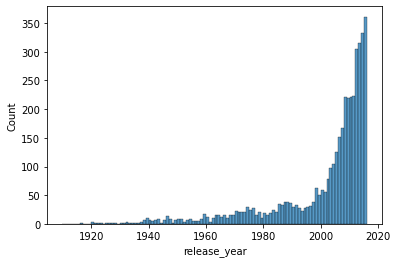

In [ ]:
sns.histplot(data = df, x = 'release_year',bins = range(1910, 2017, 1))

Use one hot encoding to deal with release_year will produce too many features. So I use 10% percentile to categorize release_year into 10 bins. Please note, use every 10 years as bins will make first several bins to have less acounts of movie. 

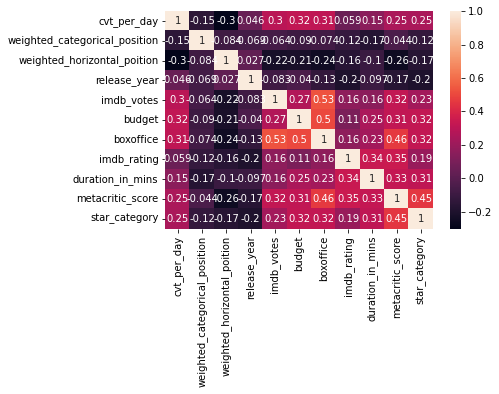

In [ ]:
# correlations between numerical features
corr_score = df[['cvt_per_day', 'weighted_categorical_position', 'weighted_horizontal_poition', 'release_year', 'imdb_votes', 'budget', 'boxoffice', 'imdb_rating', 'duration_in_mins', 'metacritic_score', 'star_category']].corr()

# show heapmap of correlations
sns.heatmap(corr_score,annot = True)

In [ ]:
# check the actual values of correlations
corr_score

,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,release_year,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category
cvt_per_day,1.000000,-0.148000,-0.301663,0.045859,0.297697,0.315886,0.312209,0.058894,0.152217,0.249159,0.246956
weighted_categorical_position,-0.148000,1.000000,-0.084066,-0.068902,-0.063700,-0.089899,-0.073628,-0.116443,-0.174461,-0.044317,-0.122851
weighted_horizontal_poition,-0.301663,-0.084066,1.000000,0.026634,-0.220749,-0.211356,-0.244709,-0.162021,-0.102344,-0.255015,-0.167801
release_year,0.045859,-0.068902,0.026634,1.000000,-0.082661,-0.040121,-0.128091,-0.198856,-0.096811,-0.167038,-0.198454
imdb_votes,0.297697,-0.063700,-0.220749,-0.082661,1.000000,0.272852,0.531467,0.163264,0.155670,0.321860,0.225192
budget,0.315886,-0.089899,-0.211356,-0.040121,0.272852,1.000000,0.504618,0.105671,0.251342,0.314608,0.321721
boxoffice,0.312209,-0.073628,-0.244709,-0.128091,0.531467,0.504618,1.000000,0.163673,0.226184,0.464965,0.322329
imdb_rating,0.058894,-0.116443,-0.162021,-0.198856,0.163264,0.105671,0.163673,1.000000,0.344055,0.346935,0.191768
duration_in_mins,0.152217,-0.174461,-0.102344,-0.096811,0.155670,0.251342,0.226184,0.344055,1.000000,0.327050,0.309110
metacritic_score,0.249159,-0.044317,-0.255015,-0.167038,0.321860,0.314608,0.464965,0.346935,0.327050,1.000000,0.452445


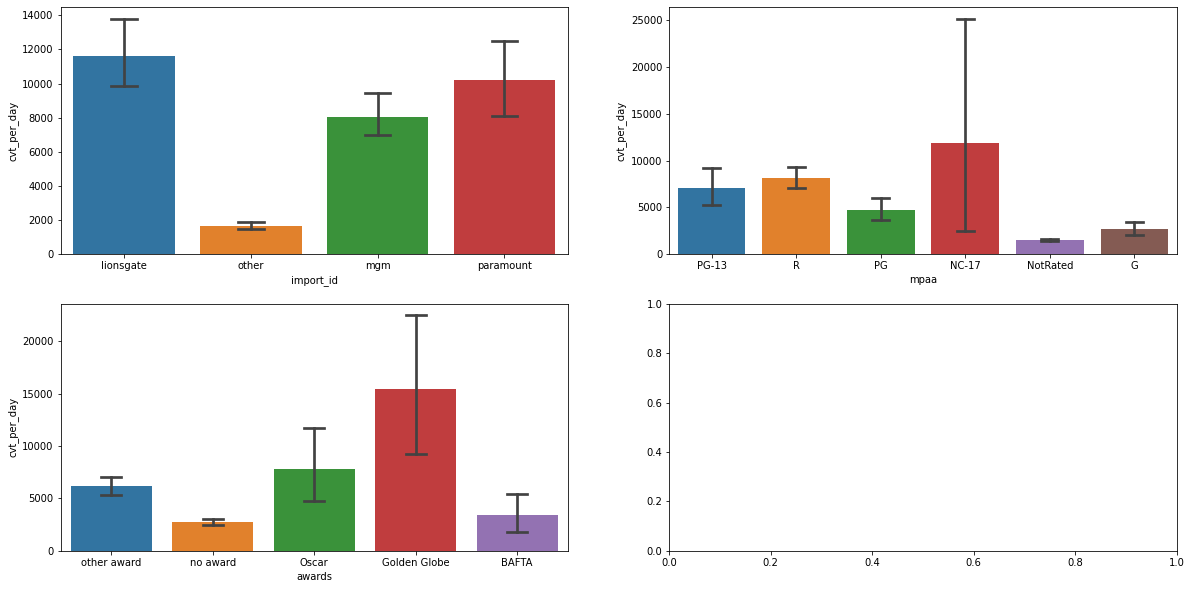

In [ ]:
# understand categorical feature
_,axss = plt.subplots(2,2, figsize=[20,10])
sns.barplot(x='import_id', y='cvt_per_day', data=df, ax=axss[0][0], estimator=np.mean, ci=95, capsize=.2)
sns.barplot(x='mpaa', y='cvt_per_day', data=df, ax=axss[0][1], estimator=np.mean, ci=95, capsize=.2)
sns.barplot(x='awards', y='cvt_per_day', data=df, ax=axss[1][0], estimator=np.mean, ci=95, capsize=.2)

In [ ]:
df['genres'].str.get_dummies(sep=',').sum().sort_values(ascending=False)

Drama                    1677
Comedy                   1184
Thriller                  879
Horror                    762
Action                    739
Documentary               671
Romance                   591
Crime                     437
Independent               393
Mystery                   375
Adventure                 363
Sci-Fi                    363
Kids & Family             280
Fantasy                   243
Music                     171
Animation                 129
War                       102
Western                   102
Sport                      77
Musicals                   68
Foreign/International      64
Anime                      11
Reality                     9
Lifestyle                   7
Adult                       3
LGBT                        2
Holiday                     1
dtype: int64

In genres, there are several features writted in one column. We need to split this column into several. And for the small portion of genres( smaller than 1% of the highest amount of genres), they will be categorized into "other_genre".  

# Part III Feature Preprocessing 

This part contains several process: 
1. categorical feature convertion by dummy variables; 
2. filling missing value; 

In [ ]:
# Convert 3 Categorical variables（'import_id'，'mpaa'，'awards'） into dummy variables
d_import_id = pd.get_dummies(df['import_id'])
d_mpaa = pd.get_dummies(df['mpaa'])
d_awards = pd.get_dummies(df['awards'])

In [ ]:
# Convert 'genres' into dummy variables
d_genres=df['genres'].str.get_dummies(sep=',')
d_genres['other_genre']=d_genres['Anime']|d_genres['Reality']|d_genres['Lifestyle']|d_genres['Adult']|d_genres['LGBT']|d_genres['Holiday']
d_genres.drop(['Anime', 'Reality','Lifestyle', 'Adult','LGBT','Holiday'], inplace=True, axis=1)

In [ ]:
# Convert 'release_year' into dummy variables
bin_year = [1916, 1974, 1991, 2001, 2006, 2008, 2010, 2012, 2013, 2014, 2017]
year_range = ['1916-1974', '1974-1991', '1991-2001', '2001-2006','2006-2008','2008-2010','2010-2012','2012-2013',
              '2013-2014','2014-2017']
year_bin = pd.cut(df['release_year'], bin_year, labels=year_range)
d_year = pd.get_dummies(year_bin)

In [ ]:
# Drop the origin categorical features and combine one-hot features
df1 = df.drop(['import_id', 'mpaa','awards','genres', 'release_year'], axis=1)
df2 = pd.concat([df1, d_import_id, d_mpaa, d_awards, d_genres, d_year], axis=1)
df2.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category,lionsgate,mgm,other,paramount,G,NC-17,NotRated,PG,PG-13,R,BAFTA,Golden Globe,Oscar,no award,other award,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Fantasy,Foreign/International,Horror,Independent,Kids & Family,Music,Musicals,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,other_genre,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,385504,307127.605608,1,3,69614,15000000,42930462,6.5,112.301017,51,1.710000,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,300175,270338.426375,1,3,46705,15000000,3301046,6.5,94.983250,41,3.250000,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,361899,256165.867446,1,3,197596,26000000,37397291,7.3,115.763675,58,2.646667,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,308314,196622.720996,3,4,356339,15000000,15700000,7.6,130.703583,94,1.666667,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
4,307201,159841.652064,1,3,46720,27220000,8551228,6.4,105.545533,37,3.066667,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


Filling missing data with mean value: 

In [ ]:
#In the data, there are 10 numerical features. It is impossible to have "0" in six features("budget", "boxoffice", "Metacritic score", "star_category", "imdb_votes", "imdb_rating"). So I replace 0 with Nan
df2[['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']] = df2[['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']].replace(0, np.nan)
df2[['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']].isnull().sum()

budget              2454
boxoffice           3194
metacritic_score    3012
star_category       1846
imdb_votes           344
imdb_rating          344
dtype: int64

In [ ]:
df2['boxoffice']=df2['boxoffice'].fillna(df2['boxoffice'].mean())
df2['metacritic_score']=df2['metacritic_score'].fillna(df2['metacritic_score'].mean())
df2['star_category']=df2['star_category'].fillna(df2['star_category'].mean())
df2['imdb_votes']=df2['imdb_votes'].fillna(df2['imdb_votes'].mean())
df2['imdb_rating']=df2['imdb_rating'].fillna(df2['imdb_rating'].mean())
df2['budget']=df2['budget'].fillna(df2['budget'].mean())
df2[['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']].isnull().sum()

budget              0
boxoffice           0
metacritic_score    0
star_category       0
imdb_votes          0
imdb_rating         0
dtype: int64

In [ ]:
# use MinMax scaler
df2_scale = df2.copy()
scale_list = ['weighted_categorical_position', 'weighted_horizontal_poition', 'budget','boxoffice','imdb_votes','imdb_rating','duration_in_mins', 'metacritic_score','star_category']
scaler = preprocessing.MinMaxScaler().fit(df2_scale[scale_list])
df2_scale[scale_list] = scaler.transform(df2_scale[scale_list])
df2_scale.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category,lionsgate,mgm,other,paramount,G,NC-17,NotRated,PG,PG-13,R,BAFTA,Golden Globe,Oscar,no award,other award,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Fantasy,Foreign/International,Horror,Independent,Kids & Family,Music,Musicals,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,other_genre,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,385504,307127.605608,0.00,0.028986,0.073379,0.140187,0.233048,0.611111,0.447409,0.505051,0.236667,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,300175,270338.426375,0.00,0.028986,0.049229,0.140187,0.017913,0.611111,0.375842,0.404040,0.750000,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,361899,256165.867446,0.00,0.028986,0.208292,0.242991,0.203010,0.700000,0.461719,0.575758,0.548889,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,308314,196622.720996,0.05,0.043478,0.375632,0.140187,0.085223,0.733333,0.523459,0.939394,0.222222,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
4,307201,159841.652064,0.00,0.028986,0.049245,0.254393,0.046415,0.600000,0.419491,0.363636,0.688889,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
# split data to train and test 
train, test = train_test_split(df2_scale, test_size=0.20, random_state = 3)
model_train_x = train.drop(['video_id', 'cvt_per_day'], axis = 1)
model_test_x = test.drop(['video_id', 'cvt_per_day'], axis = 1)
model_train_y = train['cvt_per_day']
model_test_y = test['cvt_per_day']

# Part IV: Model Training


### 0. Set up candidate models

In [ ]:
from sklearn.model_selection import train_test_split
import altair as alt

# Using X to predict y:
X = df2_scale.drop(['video_id', 'cvt_per_day'], axis = 1).copy()
y = df2_scale['cvt_per_day'].copy()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

regressors = [
    Lasso(),
    Ridge(),
    RandomForestRegressor(),
    XGBRegressor(objective='reg:squarederror')
    ]

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

kfold = KFold(n_splits=8, shuffle=True, random_state=1)

results = {}

for regressor in regressors:
    pipe = Pipeline(steps=[
                           ('regressor', regressor)
                          ])
    cv_results = cross_val_score(pipe, X_train, y_train, cv=kfold, n_jobs=-1)
    results[regressor.__class__.__name__] = cv_results

results = pd.DataFrame(results).rename_axis('K').reset_index()
results = results.melt('K', var_name='Model', value_name='Score')

In [ ]:
bars = alt.Chart(results).mark_bar().encode(
    x=alt.X('mean(Score):Q', title='Mean Score'),
    y=alt.Y('Model:N', sort=alt.EncodingSortField(op='mean', field='Score', order='descending'))
)

error_bars = bars.mark_errorbar(extent='ci').encode(
    x=alt.X('Score:Q', title='Mean Score')
)

bars + error_bars

alt.LayerChart(...)

### 1. Lasso linear regression

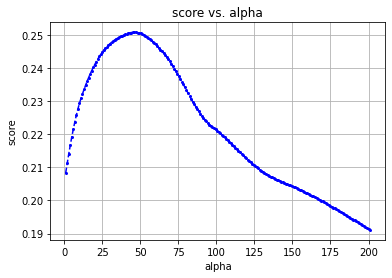

The optimaized alpha and score of Lasso linear is: 


(None, 46.226130653266324, 0.25076737901932256)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

X = train.drop(['video_id', 'cvt_per_day'], axis = 1)
y = train['cvt_per_day']

alphas = np.linspace (1, 201, num=200)
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    cv = RepeatedKFold(n_splits=10, random_state=1667)
    score = cross_val_score(lasso, X, y, cv=cv, n_jobs=-1)
    scores[i] = mean(score)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=2)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
model1_para = opt_a
print ('The optimaized alpha and score of Lasso linear is: '), opt_a, max_score


In [ ]:
lasso_f = Lasso()
lasso_f.set_params(alpha = opt_a)
lasso_f.fit(model_train_x, model_train_y)

Lasso(alpha=46.226130653266324)

### 2. Ridge linear regression

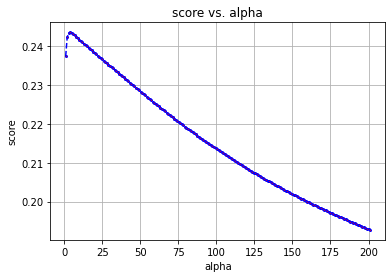

The optimaized alpha and score of Ridge linear is: 


(None, 4.015075376884422, 0.24366581384889127)

In [ ]:
# Use the same training data set as Lasso (linear features)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

X = train.drop(['video_id', 'cvt_per_day'], axis = 1)
y = train['cvt_per_day']

alphas = np.linspace (1, 201, num=200)
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    ridge = Ridge()
    ridge.set_params(alpha = a)
    cv = RepeatedKFold(n_splits=10, random_state=1667)
    score = cross_val_score(ridge, X, y, cv=cv, n_jobs=-1)
    scores[i] = mean(score)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        ridge_save = ridge
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='r', markersize=2)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
model3_para = opt_a
print ('The optimaized alpha and score of Ridge linear is: '), opt_a, max_score

In [ ]:
ridge_f = Ridge()
ridge_f.set_params(alpha = opt_a)
ridge_f.fit(model_train_x, model_train_y)

Ridge(alpha=4.015075376884422)

### 3. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rf=RandomForestRegressor(random_state=100,max_features='sqrt')
param_grid={'n_estimators':[55,56,57,58,59,60,61,62,63,64,65],'max_depth':[15,16,17,18,19,20,21]}
clf=GridSearchCV(estimator=rf,param_grid=param_grid,cv=5)
clf.fit(model_train_x,model_train_y)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_features='sqrt',
                                             random_state=100),
             param_grid={'max_depth': [15, 16, 17, 18, 19, 20, 21],
                         'n_estimators': [55, 56, 57, 58, 59, 60, 61, 62, 63,
                                          64, 65]})

{'mean_fit_time': array([0.24430461, 0.23387046, 0.23707252, 0.24019341, 0.24251032,
       0.2467257 , 0.25912786, 0.25595541, 0.26142659, 0.26870856,
       0.26467814, 0.23563323, 0.24333992, 0.2451169 , 0.24989638,
       0.25146666, 0.25978622, 0.26229935, 0.26893592, 0.26887259,
       0.27682195, 0.28411918, 0.24595203, 0.25091257, 0.25627561,
       0.25941052, 0.2618083 , 0.26622252, 0.27224145, 0.27682996,
       0.28390493, 0.28750401, 0.29250855, 0.25624318, 0.26486182,
       0.26354551, 0.26602488, 0.26714272, 0.27871885, 0.28091888,
       0.28817353, 0.28875141, 0.29603257, 0.29774098, 0.2641295 ,
       0.26533303, 0.27057228, 0.2759213 , 0.28003993, 0.28602948,
       0.29018521, 0.29637871, 0.29762521, 0.30491934, 0.30554476,
       0.26773057, 0.26825628, 0.27788258, 0.28156042, 0.28414688,
       0.28802762, 0.29832568, 0.30560079, 0.30579381, 0.30860572,
       0.31342573, 0.39323859, 0.46485624, 0.38786588, 0.28897929,
       0.29245634, 0.29906082, 0.30651946, 0

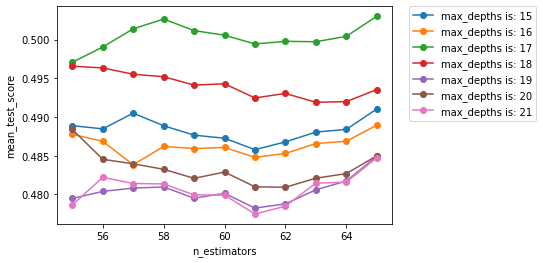

the best parameter for max_depth is: 17
the best parameter for n_estimators is: 65


In [ ]:
result=clf.cv_results_
print(result)
max_depth=[15,16,17,18,19,20,21]   
n_estimators=[55,56,57,58,59,60,61,62,63,64,65]   
scores=clf.cv_results_['mean_test_score'].reshape(len(max_depth),len(n_estimators))
plt.figure(1)
plt.subplot(1,1,1)
for i,j in enumerate(max_depth):
  plt.plot(n_estimators,scores[i],'-o',label='max_depths is: '+str(j))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('n_estimators')
plt.ylabel('mean_test_score')
plt.show()
print('the best parameter for max_depth is: '+str(clf.best_params_['max_depth']))
print('the best parameter for n_estimators is: '+str(clf.best_params_['n_estimators']))

### 4. XGBoost 

In [ ]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

xgb_model = XGBRegressor(objective='reg:squarederror')

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.01, 0.2), # default 0.1 
    "max_depth": randint(2, 8), # default 3
    "n_estimators": randint(100, 500), # default 100
    "subsample": uniform(0.6, 0.4)
}

xgb_search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=1, 
                                n_iter=400, cv=3, verbose=1, n_jobs=-1, return_train_score=True)

# Fit with early stop
eval_set = [(model_test_x, model_test_y)]
xgb_search.fit(model_train_x, model_train_y, early_stopping_rounds=10, 
               eval_metric="rmse", eval_set=eval_set, verbose=False)

print(xgb_search.best_params_)    
# print(xgb_search.best_score_)
# print(xgb_search.score(model_test_x, model_test_y))


Fitting 3 folds for each of 400 candidates, totalling 1200 fits
{'colsample_bytree': 0.7532288610604785, 'gamma': 0.41072337011314863, 'learning_rate': 0.05619771185632667, 'max_depth': 6, 'n_estimators': 291, 'subsample': 0.8643845317815337}
0.5095170000172118
0.6727787938296137


# Part V: Model Evaluation

In [ ]:
#For lasso
from sklearn.linear_model import Lasso
from sklearn.metrics import  mean_squared_error
lasso=Lasso(alpha=model1_para)
lasso.fit(model_train_x,model_train_y)
model_pred_y=lasso.predict(model_test_x)
lasso_score=lasso.score(model_test_x,model_test_y)
MSE_lasso=mean_squared_error(model_test_y,model_pred_y)
RMSE_lasso=np.sqrt(MSE_lasso)
print ('lasso score: ', lasso_score)
print ('Mean square error of lasso: ', MSE_lasso)
print ('Root mean squared error of lasso:', RMSE_lasso)

lasso score:  0.19561819601493402
Mean square error of lasso:  176256908.56232575
Root mean squared error of lasso: 13276.178236312051


In [ ]:
#for ridge
from sklearn.metrics import  mean_squared_error
ridge=Ridge(alpha=model3_para)
ridge.fit(model_train_x,model_train_y)
model_pred_y=ridge.predict(model_test_x)
ridge_score=ridge.score(model_test_x,model_test_y)
MSE_ridge=mean_squared_error(model_test_y,model_pred_y)
RMSE_ridge=np.sqrt(MSE_ridge)
print ('ridge score: ', ridge_score)
print ('Mean square error of ridge: ', MSE_ridge)
print ('Root mean squared error of ridge:', RMSE_ridge)

ridge score:  0.20953405363927124
Mean square error of ridge:  173207652.55888596
Root mean squared error of ridge: 13160.837836508965


In [ ]:
#For random forest regression
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=clf.best_params_['n_estimators'],max_depth=clf.best_params_['max_depth'],max_features='sqrt',random_state=2,n_jobs=-1)
rf.fit(model_train_x,model_train_y)
model_pred_y=rf.predict(model_test_x)
rf_score=rf.score(model_test_x,model_test_y)
MSE_rf=mean_squared_error(model_test_y,model_pred_y)
RMSE_rf=np.sqrt(MSE_rf)
print ('rf score: ', rf_score)
print ('Mean square error of rf: ', MSE_rf)
print ('Root mean squared error of rf:', RMSE_rf)


rf score:  0.5339347125218485
Mean square error of rf:  102124670.58819214
Root mean squared error of rf: 10105.675167359781


In [ ]:
#For XGBoost
from xgboost import XGBRegressor
xgb=XGBRegressor(objective='reg:squarederror',
                colsample_bytree=xgb_search.best_params_['colsample_bytree'],
                gamma=xgb_search.best_params_['gamma'],
                learning_rate=xgb_search.best_params_['learning_rate'],
                max_depth=xgb_search.best_params_['max_depth'],
                n_estimators=xgb_search.best_params_['n_estimators'],
                subsample=xgb_search.best_params_['subsample'],
                random_state=2,n_jobs=-1)
xgb.fit(model_train_x,model_train_y)
model_pred_y=xgb.predict(model_test_x)
xgb_score=xgb.score(model_test_x,model_test_y)
MSE_xgb=mean_squared_error(model_test_y,model_pred_y)
RMSE_xgb=np.sqrt(MSE_xgb)
print ('xgb score: ', xgb_score)
print ('Mean square error of xgb: ', MSE_xgb)
print ('Root mean squared error of xgb:', RMSE_xgb)

xgb score:  0.6647256423907684
Mean square error of xgb:  73465637.21314609
Root mean squared error of xgb: 8571.209787022255


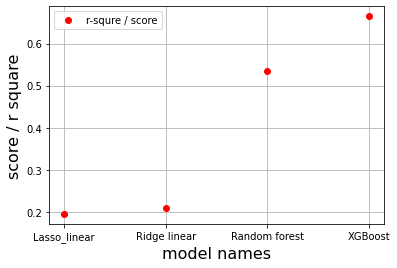

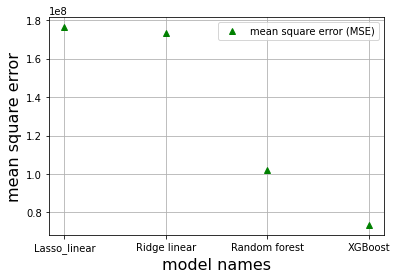

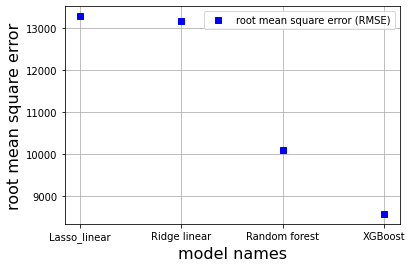

In [ ]:
lst_score = [lasso_score, ridge_score, rf_score, xgb_score]
MSE_lst =  [MSE_lasso, MSE_ridge, MSE_rf, MSE_xgb]
RMSE_lst =  [RMSE_lasso, RMSE_ridge, RMSE_rf, RMSE_xgb]
model_lst = ['Lasso_linear', 'Ridge linear', 'Random forest', 'XGBoost']

plt.figure(1)
plt.plot(model_lst, lst_score, 'ro')
plt.legend(['r-squre / score'])
plt.xlabel('model names',fontsize =16)
plt.ylabel('score / r square', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(2)
plt.plot(model_lst, MSE_lst, 'g^')
plt.legend(['mean square error (MSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('mean square error', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(3)
plt.plot(model_lst, RMSE_lst, 'bs')
plt.legend(['root mean square error (RMSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('root mean square error', fontsize =16)
plt.grid(True)
plt.show()

### Feature importance

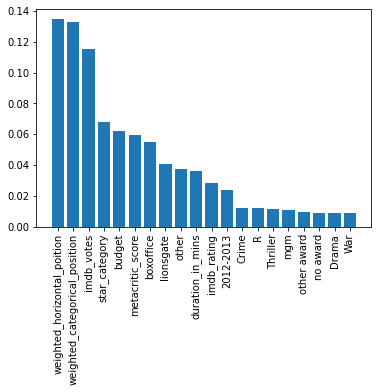

In [ ]:
importances = rf.feature_importances_
feature_name = model_train_x.columns.values
indices = np.argsort(importances)[::-1]
plt.figure(1)
plt.bar(feature_name[indices[:20]], importances[indices[:20]])
plt.xticks(rotation=90)
plt.show()

# Conclusion: 

Among these models, XGBoost has the best performance. 

Among these features, weighted_categorical_position, weighted_horizontal_poition are the most important. So, the place position of video is important to get it exposed to the audience.  